# FraudWatch — Modelo Principal e Seleção

## Objetivo deste notebook

Este notebook consolida o **modelo principal de risco da POC FraudWatch**, avançando além do baseline e avaliando modelos mais expressivos para dados tabulares desbalanceados.

O escopo vai além da otimização isolada de métricas, contemplando:

* comparação de modelos candidatos sob critérios consistentes;
* validação de ganhos reais em relação ao baseline;
* seleção de um **modelo campeão**, equilibrando performance preditiva e custo operacional;
* preparação do modelo para integração com uma camada explícita de decisão.

---

## Papel deste notebook na POC FraudWatch

No contexto da FraudWatch, este notebook é responsável por:

* avaliar a **capacidade de ordenação de risco** de modelos avançados;
* comparar abordagens de boosting e baseline de forma justa e auditável;
* explicitar os impactos operacionais associados às escolhas de modelo;
* definir **um único modelo campeão**, estável e versionado.

O foco desloca-se da simples maximização de métricas para a identificação do modelo que **sustenta de forma mais robusta uma decisão de negócio**.

---

## Escopo e decisões importantes

* Os dados utilizados foram **auditados e particionados temporalmente** no Notebook 01.
* O particionamento segue a lógica **train / validation / test**, utilizando `Time` como proxy temporal.
* O conjunto de validação é empregado para:

  * comparação entre modelos,
  * ajuste controlado de hiperparâmetros,
  * definição do threshold de decisão.
* O conjunto de teste é mantido como **holdout final**, sem influência nas decisões de modelagem.
* Os modelos avaliados incluem:

  * baseline de Regressão Logística (referência),
  * XGBoost,
  * LightGBM.
* A seleção do modelo campeão considera, de forma conjunta:

  * PR-AUC,
  * precision / recall,
  * F1-score,
  * volume de alertas gerados (custo operacional).

---

## O que este notebook entrega

Ao final, este notebook entrega:

* modelos candidatos treinados e avaliados sob um protocolo comum;
* comparação explícita entre baseline e modelos de boosting;
* um **modelo campeão selecionado e validado**;
* avaliação final no conjunto de teste (holdout);
* persistência dos artefatos do modelo campeão e de suas métricas associadas.

Este notebook encerra a **fase de modelagem da FraudWatch**.
A etapa seguinte concentra-se exclusivamente na **camada de decisioning**, na qual o score é transformado em ação (Notebook 04).

## 1. Setup e parâmetros globais

In [1]:
# Importação de bibliotecas

# 1. Standard library
import json
import sys
from datetime import datetime

sys.path.insert(0, "..")

# 2. Third-party
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 3. Local (projeto)
from src.utils import to_jsonable

from src.paths import (
    PROCESSED_TRAIN,
    PROCESSED_VALID,
    PROCESSED_TEST,
    PROCESSED_SPLIT_METADATA,
    ANALYSIS_FOLDER,
    MODELS_FOLDER,
    PLOTS_FOLDER,
    CHAMPION_METRICS_TEST,
    CHAMPION_METRICS_VALID,
)

from src.evaluation import (
    make_threshold_table,
    select_threshold,
    evaluate_on_valid,
    plot_pr_curve,
    plot_confusion,
)

# 4. Config (plots)
sns.set_theme(style="whitegrid", context="notebook")

In [2]:
SEED = 42
np.random.seed(SEED)

TARGET_COL = "Class"
TIME_COL = "Time"
USE_TIME_AS_FEATURE = False

PRIMARY_METRIC = "PR-AUC"
MIN_PRECISION = 0.10

## 2. Carregar e validar dados processados

In [3]:
# Carrega dados
train_df = pd.read_parquet(PROCESSED_TRAIN)
valid_df = pd.read_parquet(PROCESSED_VALID)
test_df  = pd.read_parquet(PROCESSED_TEST)

In [4]:
with open(PROCESSED_SPLIT_METADATA, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

In [5]:
df_splits = (
    pd.DataFrame.from_dict(split_meta["splits"], orient="index")
      .reset_index()
      .rename(columns={"index": "split"})
      .rename(columns={"time_min": "time_min_s", "time_max": "time_max_s"})
)

df_splits.style.format({
    "rows": "{:,}",
    "fraud_rate": "{:.4%}",
    "time_min_s": "{:,}",
    "time_max_s": "{:,}",
})

,split,rows,fraud_rate,time_min_s,time_max_s
0,train,"198,608",0.1843%,0.0,"132,906.0"
1,valid,"42,559",0.1292%,"132,906.0","151,320.0"
2,test,"42,559",0.1222%,"151,320.0","172,792.0"


## 3. Preparação de features/target

In [6]:
DROP_COLS = [TARGET_COL]
if (not USE_TIME_AS_FEATURE) and (TIME_COL in train_df.columns):
    DROP_COLS.append(TIME_COL)

In [7]:
def make_xy(df):
    X = df.drop(columns=DROP_COLS)
    y = df[TARGET_COL].astype(int)
    return X, y

In [8]:
# Separação dos splits
X_train, y_train = make_xy(train_df)
X_valid, y_valid = make_xy(valid_df)
X_test,  y_test  = make_xy(test_df)

In [9]:
# Sanity checks anti-vazamento
assert TARGET_COL not in X_train.columns
assert TARGET_COL not in X_valid.columns
assert TARGET_COL not in X_test.columns

if not USE_TIME_AS_FEATURE:
    assert TIME_COL not in X_train.columns

In [10]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

X_train: (198608, 29) y_train: (198608,)
X_valid: (42559, 29) y_valid: (42559,)
X_test : (42559, 29) y_test : (42559,)


## 4. Baseline reference (VALID)

In [11]:
BASELINE_PATH = MODELS_FOLDER / "baseline_logreg.pkl"

baseline_model = joblib.load(BASELINE_PATH)

# Probabilidade de fraude (classe 1) no VALID
proba_valid_baseline = baseline_model.predict_proba(X_valid)[:, 1]

# Avaliação padronizada (gera threshold pela política e retorna métricas)
baseline_eval = evaluate_on_valid(
    model_name="Baseline_LogReg",
    y_valid=y_valid,
    proba_valid=proba_valid_baseline,
    min_precision=MIN_PRECISION,
)

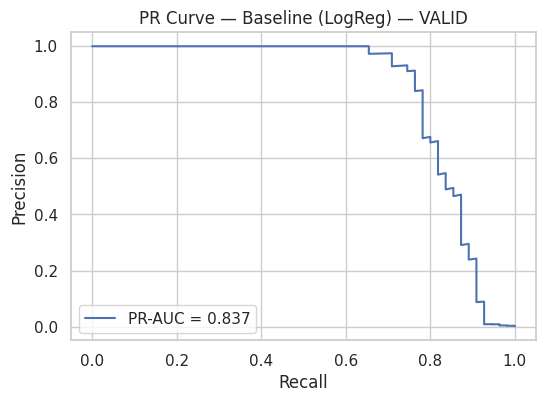

np.float64(0.8371646967543983)

In [12]:
# PR curve do baseline
plot_pr_curve(
    y_true=y_valid,
    proba=proba_valid_baseline,
    title="PR Curve — Baseline (LogReg) — VALID",
    savepath=None,
)

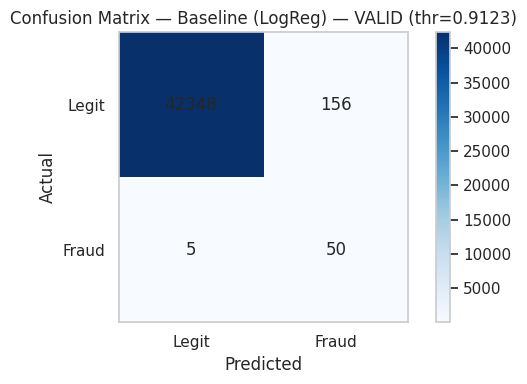

In [13]:
# Confusion Matrix no threshold escolhido pela política
cm_baseline = baseline_eval["confusion_matrix_valid"]

plot_confusion(
    cm=cm_baseline,
    title=f"Confusion Matrix — Baseline (LogReg) — VALID (thr={baseline_eval['chosen_threshold']:.4f})",
    savepath=None,
)

In [14]:
# Resumo rápido
baseline_summary = {
    "model": baseline_eval["model"],
    "pr_auc_valid": baseline_eval["pr_auc_valid"],
    "chosen_threshold": baseline_eval["chosen_threshold"],
    "precision_valid": baseline_eval["precision_valid"],
    "recall_valid": baseline_eval["recall_valid"],
    "f1_valid": baseline_eval["f1_valid"],
    "alerts_valid": baseline_eval["alerts_valid"],
    "alert_rate_valid": baseline_eval["alert_rate_valid"],
}

pd.DataFrame([baseline_summary])

,model,pr_auc_valid,chosen_threshold,precision_valid,recall_valid,f1_valid,alerts_valid,alert_rate_valid
0,Baseline_LogReg,0.837165,0.912264,0.242718,0.909091,0.383142,206,0.00484


## 5. Treino e validação dos modelos candidatos

Nesta etapa, são treinados modelos de maior capacidade preditiva para comparação direta com o baseline de Regressão Logística.

A seleção dos modelos candidatos considera os seguintes critérios:

- robustez frente a dados tabulares altamente desbalanceados;
- capacidade consistente de ordenação de risco;
- suporte a técnicas de explicabilidade;
- uso recorrente em sistemas antifraude em produção.

Para mitigar riscos de vazamento temporal, o protocolo adotado contempla:

- treinamento restrito ao conjunto de treino;
- aplicação de early stopping com base no conjunto de validação;
- ausência de validação cruzada aleatória.

O critério de comparação é mantido consistente com o baseline, utilizando a mesma política de definição de threshold baseada em precisão mínima.

### 5.1 Modelo candidato: XGBoost

O XGBoost é um modelo de gradient boosting amplamente empregado em problemas com dados tabulares, apresentando boa capacidade de capturar não linearidades e interações entre variáveis.

Nesta POC, é adotada uma configuração regularizada e reprodutível. O uso de early stopping não é aplicado, em função de diferenças de API entre versões recentes do XGBoost, preservando a consistência do protocolo experimental e a comparabilidade com o baseline.

In [15]:
# Peso para desbalanceamento
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=1200,
    max_depth=3,
    learning_rate=0.03,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=5.0,
    reg_alpha=0.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    n_jobs=-1,
)

In [16]:
# Treino
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [17]:
# Probabilidades no VALID
proba_valid_xgb = xgb_model.predict_proba(X_valid)[:, 1]

# Avaliação padronizada
xgb_eval = evaluate_on_valid(
    model_name="XGBoost",
    y_valid=y_valid,
    proba_valid=proba_valid_xgb,
    min_precision=MIN_PRECISION,
)

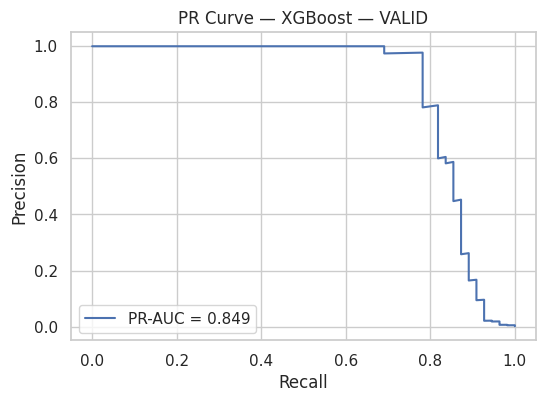

In [18]:
# PR Curve
_ = plot_pr_curve(
    y_true=y_valid,
    proba=proba_valid_xgb,
    title="PR Curve — XGBoost — VALID",
)

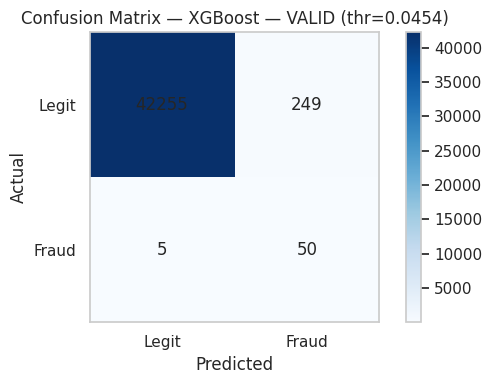

In [19]:
# Confusion Matrix
plot_confusion(
    cm=xgb_eval["confusion_matrix_valid"],
    title=f"Confusion Matrix — XGBoost — VALID (thr={xgb_eval['chosen_threshold']:.4f})",
)

In [20]:
# Resumo para comparação
xgb_summary = {
    "model": xgb_eval["model"],
    "pr_auc_valid": xgb_eval["pr_auc_valid"],
    "chosen_threshold": xgb_eval["chosen_threshold"],
    "precision_valid": xgb_eval["precision_valid"],
    "recall_valid": xgb_eval["recall_valid"],
    "f1_valid": xgb_eval["f1_valid"],
    "alerts_valid": xgb_eval["alerts_valid"],
    "alert_rate_valid": xgb_eval["alert_rate_valid"],
}

pd.DataFrame([xgb_summary])

,model,pr_auc_valid,chosen_threshold,precision_valid,recall_valid,f1_valid,alerts_valid,alert_rate_valid
0,XGBoost,0.848688,0.045419,0.167224,0.909091,0.282486,299,0.007026


### 5.2 Modelo candidato: LightGBM

O LightGBM apresenta o melhor trade-off operacional no conjunto de validação, combinando alta capacidade de ordenação de risco (PR-AUC) com menor custo operacional, refletido no volume de alertas gerados sob a mesma política de decisão.

É adotada uma configuração regularizada e conservadora, com foco na maximização da estabilidade e da reprodutibilidade no contexto temporal desta POC.

In [21]:
lgbm_model = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=15,
    min_data_in_leaf=200,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=5.0,
    reg_alpha=0.0,
    objective="binary",
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1,
)

In [22]:
# Treino
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 366, number of negative: 198242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 198608, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               learning_rate=0.03, min_data_in_leaf=200, n_estimators=1200,
               n_jobs=-1, num_leaves=15, objective='binary', random_state=42,
               reg_lambda=5.0, subsample=0.7)

In [23]:
# Probabilidades no VALID
proba_valid_lgbm = lgbm_model.predict_proba(X_valid)[:, 1]

# Avaliação padronizada
lgbm_eval = evaluate_on_valid(
    model_name="LightGBM",
    y_valid=y_valid,
    proba_valid=proba_valid_lgbm,
    min_precision=MIN_PRECISION,
)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


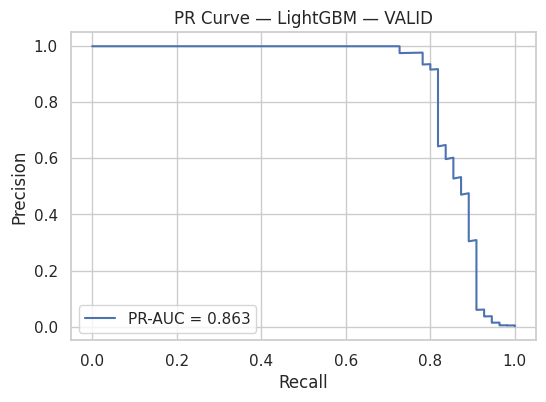

In [24]:
# PR Curve
_ = plot_pr_curve(
    y_true=y_valid,
    proba=proba_valid_lgbm,
    title="PR Curve — LightGBM — VALID",
    savepath=PLOTS_FOLDER / "pr_curve_lgbm_valid.png",
)

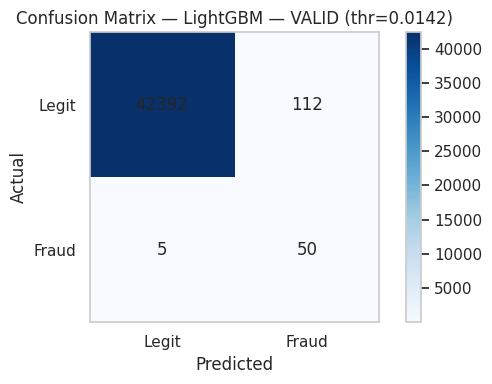

In [25]:
# Confusion Matrix
plot_confusion(
    cm=lgbm_eval["confusion_matrix_valid"],
    title=f"Confusion Matrix — LightGBM — VALID (thr={lgbm_eval['chosen_threshold']:.4f})",
    savepath=PLOTS_FOLDER / "cm_lgbm_valid.png",
)

In [26]:
# Resumo para comparação
lgbm_summary = {
    "model": lgbm_eval["model"],
    "pr_auc_valid": lgbm_eval["pr_auc_valid"],
    "chosen_threshold": lgbm_eval["chosen_threshold"],
    "precision_valid": lgbm_eval["precision_valid"],
    "recall_valid": lgbm_eval["recall_valid"],
    "f1_valid": lgbm_eval["f1_valid"],
    "alerts_valid": lgbm_eval["alerts_valid"],
    "alert_rate_valid": lgbm_eval["alert_rate_valid"],
}

pd.DataFrame([lgbm_summary])

,model,pr_auc_valid,chosen_threshold,precision_valid,recall_valid,f1_valid,alerts_valid,alert_rate_valid
0,LightGBM,0.863162,0.014186,0.308642,0.909091,0.460829,162,0.003806


## 6. Tabela comparativa e escolha do campeão

In [27]:
results_df = pd.DataFrame([
    baseline_summary,
    xgb_summary,
    lgbm_summary,
]).sort_values(by="pr_auc_valid", ascending=False)

results_df

,model,pr_auc_valid,chosen_threshold,precision_valid,recall_valid,f1_valid,alerts_valid,alert_rate_valid
2,LightGBM,0.863162,0.014186,0.308642,0.909091,0.460829,162,0.003806
1,XGBoost,0.848688,0.045419,0.167224,0.909091,0.282486,299,0.007026
0,Baseline_LogReg,0.837165,0.912264,0.242718,0.909091,0.383142,206,0.004840


## 6. Seleção do modelo campeão (performance × custo operacional)

Após o treinamento e a avaliação dos modelos candidatos no conjunto de validação (split temporal), sob a mesma política de decisão, baseada em precisão mínima e definição de threshold, é realizada a comparação entre o baseline de Regressão Logística e os modelos de boosting (XGBoost e LightGBM).

A comparação adota uma abordagem multicritério, visando identificar o melhor trade-off entre:

- capacidade de ordenação de risco (PR-AUC);
- qualidade do sinal preditivo (precision e recall);
- custo operacional, refletido no volume de alertas gerados (alert_rate).

In [28]:
# Ordena por critérios (ajuste se quiser priorizar outro)
results_df_sorted = results_df.sort_values(
    by=["f1_valid", "pr_auc_valid", "alert_rate_valid"],
    ascending=[False, False, True]
)

results_df_sorted

,model,pr_auc_valid,chosen_threshold,precision_valid,recall_valid,f1_valid,alerts_valid,alert_rate_valid
2,LightGBM,0.863162,0.014186,0.308642,0.909091,0.460829,162,0.003806
0,Baseline_LogReg,0.837165,0.912264,0.242718,0.909091,0.383142,206,0.004840
1,XGBoost,0.848688,0.045419,0.167224,0.909091,0.282486,299,0.007026


In [29]:
# Threshold fixo escolhido no VALID (da política min_precision)
champion_threshold_valid = float(lgbm_eval["chosen_threshold"])
print(f"Threshold fixo (VALID) do campeão: {champion_threshold_valid:.6f}")


Threshold fixo (VALID) do campeão: 0.014186


In [30]:
champion_name = results_df_sorted.iloc[0]["model"]
print("Modelo campeão:", champion_name)


Modelo campeão: LightGBM


### Resultado

O **LightGBM** apresenta o melhor desempenho geral no conjunto de validação, atendendo de forma mais consistente aos critérios definidos para a seleção do modelo campeão:

- maior PR-AUC, indicando melhor capacidade de ordenação de risco;
- melhor F1-score;
- menor volume de alertas entre os modelos avaliados, com preservação de alto recall.

Além dos ganhos de performance, o LightGBM demonstra aderência adequada ao contexto da POC, combinando eficiência em dados tabulares, escalabilidade e suporte a técnicas de explicabilidade.

Com base nesses resultados, o **LightGBM é selecionado como modelo campeão** para a etapa final de avaliação no conjunto de teste.

## 7. Avaliação final no TEST (holdout) e persistência do campeão

Nesta etapa, o modelo campeão é avaliado no conjunto de teste (holdout), empregado uma única vez ao final do pipeline.

Diretrizes adotadas para esta avaliação:

- o conjunto TEST não é utilizado para ajustes, seleção de threshold ou tuning;
- o threshold aplicado no TEST é o mesmo definido no conjunto VALID;
- o objetivo é verificar se o trade-off entre performance e custo operacional se mantém fora do conjunto de validação.

Ao final do processo, os artefatos do modelo campeão são persistidos para uso downstream, incluindo o modelo treinado, as métricas finais e os relatórios de comparação.

### 7.1 Avaliação no TEST

In [31]:
# Probabilidade no TEST
proba_test_champion = lgbm_model.predict_proba(X_test)[:, 1]

# PR-AUC no TEST (métrica de ranking)
pr_auc_test = average_precision_score(y_test, proba_test_champion)

# Classificação no TEST com threshold fixo do VALID
pred_test = (proba_test_champion >= champion_threshold_valid).astype(int)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


In [32]:
prec_test = precision_score(y_test, pred_test, zero_division=0)
rec_test  = recall_score(y_test, pred_test, zero_division=0)
f1_test   = f1_score(y_test, pred_test, zero_division=0)
cm_test   = confusion_matrix(y_test, pred_test)

alerts_test = int(pred_test.sum())
alert_rate_test = alerts_test / len(y_test)

print(f"\nPR-AUC (TEST): {pr_auc_test:.6f}")
print(f"Threshold (fixo do VALID): {champion_threshold_valid:.6f}")
print(f"Precision (TEST): {prec_test:.6f}")
print(f"Recall    (TEST): {rec_test:.6f}")
print(f"F1        (TEST): {f1_test:.6f}")
print(f"Alerts    (TEST): {alerts_test} | Alert rate: {alert_rate_test:.6%}")


PR-AUC (TEST): 0.768030
Threshold (fixo do VALID): 0.014186
Precision (TEST): 0.261438
Recall    (TEST): 0.769231
F1        (TEST): 0.390244
Alerts    (TEST): 153 | Alert rate: 0.359501%


In [33]:
print("\nClassification report (TEST):")
print(classification_report(y_test, pred_test, digits=4, zero_division=0))


Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9997    0.9973    0.9985     42507
           1     0.2614    0.7692    0.3902        52

    accuracy                         0.9971     42559
   macro avg     0.6306    0.8833    0.6944     42559
weighted avg     0.9988    0.9971    0.9978     42559



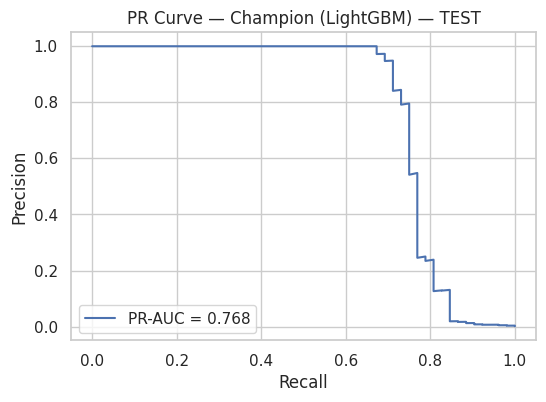

In [34]:
# Plots (usando suas funções padronizadas)
_ = plot_pr_curve(
    y_true=y_test,
    proba=proba_test_champion,
    title="PR Curve — Champion (LightGBM) — TEST",
    savepath=PLOTS_FOLDER / "pr_curve_lgbm_test.png",
)

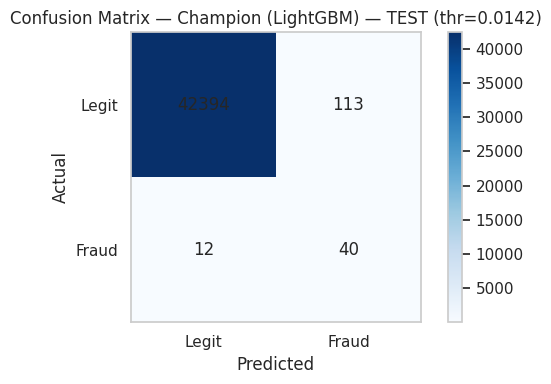

In [35]:
plot_confusion(
    cm=cm_test,
    title=f"Confusion Matrix — Champion (LightGBM) — TEST (thr={champion_threshold_valid:.4f})",
    savepath=PLOTS_FOLDER / "cm_curve_lgbm_test.png",
)

#### Interpretação (TEST)

O conjunto de teste é empregado exclusivamente para a validação final do modelo campeão, sem qualquer ajuste adicional de threshold ou parâmetros.

Os resultados observados indicam comportamento consistente em dados não vistos, com manutenção do trade-off definido no conjunto de validação.

- **PR-AUC (TEST = 0.77)** evidencia que o modelo preserva boa capacidade de ordenação de risco fora do conjunto de validação.
- **Recall (≈ 77%)** demonstra que a maior parte das fraudes continua sendo capturada, sem necessidade de reotimização do threshold.
- **Precision (≈ 26%)**, combinada a um **alert rate inferior a 0,4%**, reflete um custo operacional controlado e compatível com cenários reais de revisão manual.

A estabilidade das métricas entre validação e teste indica boa capacidade de generalização, habilitando o modelo a avançar para a camada de **decisioning**, na qual o score será convertido em políticas explícitas de ação (Notebook 04).

### 7.2 Persistência de artefatos do campeão

In [36]:
# Salvar modelo campeão
champion_model_path = MODELS_FOLDER / "champion_lightgbm.pkl"
joblib.dump(lgbm_model, champion_model_path)

['/home/jhonathan/sdl/POC/fraudwacth/models/champion_lightgbm.pkl']

In [37]:
#Salvar métricas VALID e TEST (JSON)
champion_metrics_valid = {
    "model": "LightGBM",
    "dataset": "VALID",
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "pr_auc": to_jsonable(lgbm_eval["pr_auc_valid"]),
    "threshold_policy": lgbm_eval.get("threshold_policy", f"max_recall_with_precision>={MIN_PRECISION}"),
    "chosen_threshold": to_jsonable(lgbm_eval["chosen_threshold"]),
    "precision": to_jsonable(lgbm_eval["precision_valid"]),
    "recall": to_jsonable(lgbm_eval["recall_valid"]),
    "f1": to_jsonable(lgbm_eval["f1_valid"]),
    "alerts": to_jsonable(lgbm_eval["alerts_valid"]),
    "alert_rate": to_jsonable(lgbm_eval["alert_rate_valid"]),
    "confusion_matrix": to_jsonable(lgbm_eval["confusion_matrix_valid"]),
}

champion_metrics_test = {
    "model": "LightGBM",
    "dataset": "TEST",
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "pr_auc": to_jsonable(pr_auc_test),
    "chosen_threshold": to_jsonable(champion_threshold_valid),
    "precision": to_jsonable(prec_test),
    "recall": to_jsonable(rec_test),
    "f1": to_jsonable(f1_test),
    "alerts": to_jsonable(alerts_test),
    "alert_rate": to_jsonable(alert_rate_test),
    "confusion_matrix": to_jsonable(cm_test),
}

with open(CHAMPION_METRICS_VALID, "w", encoding="utf-8") as f:
    json.dump(champion_metrics_valid, f, indent=2, ensure_ascii=False)

with open(CHAMPION_METRICS_TEST, "w", encoding="utf-8") as f:
    json.dump(champion_metrics_test, f, indent=2, ensure_ascii=False)

In [38]:
# Salvar comparação da shortlist
shortlist_path = ANALYSIS_FOLDER/ "shortlist_comparison.parquet"
results_df_sorted.to_parquet(shortlist_path, index=False)

## Encerramento

Este notebook consolida o modelo principal da FraudWatch, contemplando as seguintes entregas:

* Treinamento e avaliação comparativa de modelos candidatos (Baseline, XGBoost e LightGBM) sob um mesmo split temporal.
* Seleção do modelo campeão com base no trade-off entre capacidade de ordenação de risco (PR-AUC), qualidade do sinal preditivo e custo operacional.
* Ajuste controlado de hiperparâmetros no conjunto de validação, visando a validação de ganhos reais de performance.
* Definição e fixação de uma política de threshold no conjunto de validação.
* Avaliação final do modelo campeão no conjunto de teste (holdout), sem ajuste de decisões.
* Verificação da estabilidade do modelo por meio da consistência de desempenho entre os conjuntos VALID e TEST.
* Persistência dos artefatos do modelo campeão e das métricas de avaliação para uso downstream.

Com isso, a FraudWatch passa a dispor de um **modelo campeão validado, estável e versionado**, apto para integração com uma **camada explícita de decisioning**, a ser desenvolvida no Notebook 04.